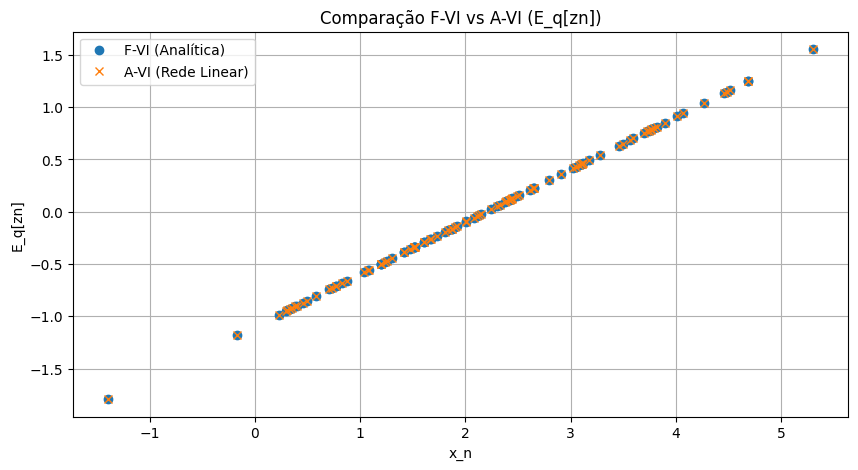

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Configurações do modelo
N = 100                     # Número de dados
tau = 1.0                   # τ
sigma = 1.0                 # σ
torch.manual_seed(0)

# Gerando dados
z_true = torch.randn(N)  # zn ~ N(0,1)
theta = torch.tensor(2.0)  # θ fixo
x_data = theta + tau * z_true + sigma * torch.randn(N)  # xn | zn, θ

# === Solução Analítica da F-VI ===
x_bar = x_data.mean()
alpha = tau / (sigma**2 + tau**2)
alpha0 = -tau * x_bar / (sigma**2 + tau**2)

mu_fvi = alpha0 + alpha * x_data  # E_q[zn] solução analítica
var_fvi = (sigma**2 * 1.0) / (sigma**2 + tau**2)  # constante ξ²

# === Inferência Amortizada: Rede Linear ===
class InferenceNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # apenas 2 parâmetros: peso e bias
        self.log_std = nn.Parameter(torch.tensor(0.0))  # variância constante

    def forward(self, x):
        x = x.view(-1, 1)
        mu = self.linear(x)
        std = torch.exp(self.log_std)
        return mu.squeeze(), std

net = InferenceNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_fn = lambda mu, target: ((mu - target)**2).mean()

# Treinando a rede para aprender a estrutura da solução analítica
for epoch in range(1000):
    mu_pred, std_pred = net(x_data)
    loss = loss_fn(mu_pred, mu_fvi.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# === Comparação ===
mu_avi, std_avi = net(x_data)

plt.figure(figsize=(10,5))
plt.plot(x_data, mu_fvi, 'o', label='F-VI (Analítica)')
plt.plot(x_data, mu_avi.detach(), 'x', label='A-VI (Rede Linear)')
plt.xlabel('x_n')
plt.ylabel('E_q[zn]')
plt.title('Comparação F-VI vs A-VI (E_q[zn])')
plt.legend()
plt.grid()
plt.show()


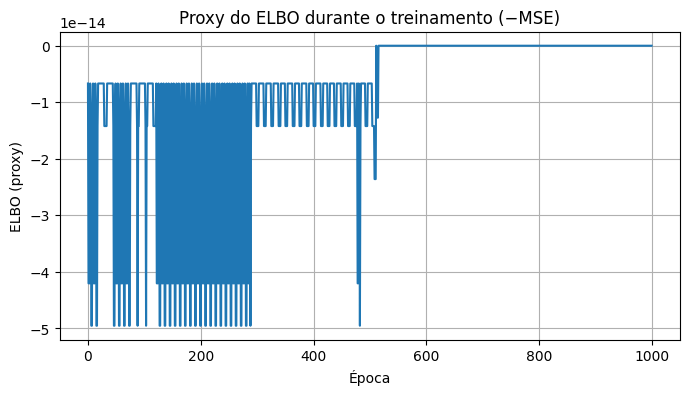

In [5]:
# Salvar histórico do ELBO (proxy: -MSE)
elbo_history = []

for epoch in range(1000):
    mu_pred, std_pred = net(x_data)
    loss = loss_fn(mu_pred, mu_fvi.detach())
    elbo_history.append(-loss.item())  # Negativo do MSE como proxy do ELBO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot ELBO
plt.figure(figsize=(8,4))
plt.plot(elbo_history)
plt.title('Proxy do ELBO durante o treinamento (−MSE)')
plt.xlabel('Época')
plt.ylabel('ELBO (proxy)')
plt.grid()
plt.show()


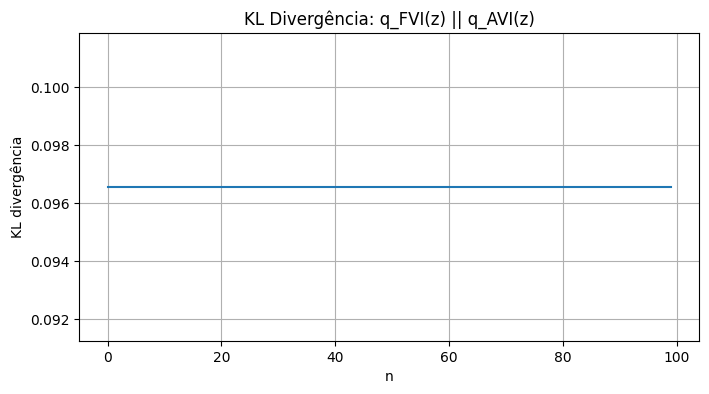

KL média: 0.0966


In [6]:
from torch.distributions import Normal

# Distribuições variacionais
q_fvi = Normal(mu_fvi, var_fvi**0.5)
q_avi = Normal(mu_avi.detach(), std_avi.detach())

# KL divergência KL(q_FVI || q_AVI)
kl = torch.distributions.kl_divergence(q_fvi, q_avi)
plt.figure(figsize=(8,4))
plt.plot(kl)
plt.title('KL Divergência: q_FVI(z) || q_AVI(z)')
plt.xlabel('n')
plt.ylabel('KL divergência')
plt.grid()
plt.show()

print(f"KL média: {kl.mean().item():.4f}")


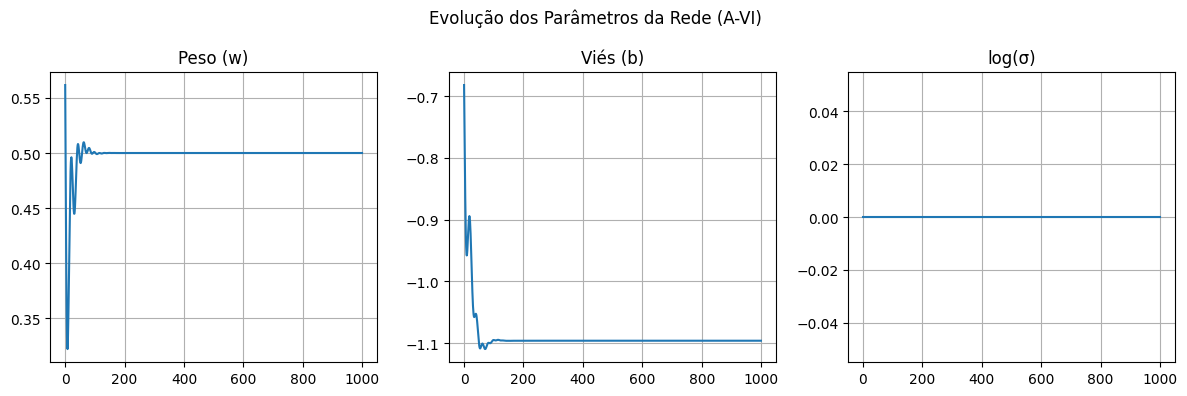

In [7]:
# Re-inicializa rede e histórico de parâmetros
net = InferenceNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

# Históricos
weight_hist, bias_hist, logstd_hist = [], [], []

for epoch in range(1000):
    mu_pred, std_pred = net(x_data)
    loss = loss_fn(mu_pred, mu_fvi.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Armazenar parâmetros
    with torch.no_grad():
        w = net.linear.weight.item()
        b = net.linear.bias.item()
        logstd = net.log_std.item()
        weight_hist.append(w)
        bias_hist.append(b)
        logstd_hist.append(logstd)

# Plot evolução dos parâmetros
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(weight_hist)
plt.title('Peso (w)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(bias_hist)
plt.title('Viés (b)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(logstd_hist)
plt.title('log(σ)')
plt.grid()

plt.suptitle('Evolução dos Parâmetros da Rede (A-VI)')
plt.tight_layout()
plt.show()
